In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, auc, make_scorer, recall_score, precision_score, cohen_kappa_score

In [37]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [41]:
ha['sex'] = ha['sex'].astype('category')
ha['cp'] = ha['cp'].astype('category')
ha['restecg'] = ha['restecg'].astype('category')
ha['output'] = ha['output'].astype('category')

In [42]:
ha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   age      273 non-null    int64   
 1   sex      273 non-null    category
 2   cp       273 non-null    category
 3   trtbps   273 non-null    int64   
 4   chol     273 non-null    int64   
 5   restecg  273 non-null    category
 6   thalach  273 non-null    int64   
 7   output   273 non-null    category
dtypes: category(4), int64(4)
memory usage: 10.3 KB


## Data Preprocessing

In [43]:
X = ha.drop(['output'], axis = 1)
y = ha['output']

enc = OneHotEncoder()

ct = ColumnTransformer(
  [
    ("dummify",
    enc,
    make_column_selector(dtype_include='category')),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)


# Part One: Fitting Models

## KNN

In [44]:
knn = KNeighborsClassifier()

#create a pipeline with preprocessing and the model
knn_pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', knn)
])

#define the parameter grid for hyperparameter tuning
knn_param_grid = {
    'classifier__n_neighbors': np.arange(1, 31),  # Testing different numbers of neighbors
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

#grid search for cross validation
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='roc_auc')

#fit to data
knn_grid_search.fit(X, y)

#store best model's parameters and score
best_knn_model = knn_grid_search.best_estimator_
best_knn_params = knn_grid_search.best_params_
best_knn_score = knn_grid_search.best_score_

best_knn_params, best_knn_score

({'classifier__metric': 'manhattan',
  'classifier__n_neighbors': 30,
  'classifier__weights': 'uniform'},
 0.8431844385499557)

The ROC AUC score of 0.843 indicates a solid job at predicting the classification of at risk for heart attack vs. not at risk.

In [45]:
#make predictions
knn_preds = knn_grid_search.predict(X)

In [46]:
#knn confusion matrix
knn_confusion_matrix = confusion_matrix(y, knn_preds)
knn_confusion_matrix

array([[105,  22],
       [ 38, 108]])

- True Positives (TP): 105
- False Positives (FP): 38
- True Negatives (TN): 108
- False Negatives (FN): 22

## Logistic Regression

In [47]:
log_reg = LogisticRegression()

#create a pipeline with preprocessing and the model
log_pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', log_reg)
])

#define parameter grid for hyperparameter tuning
log_param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),  # Testing a range of regularization strengths
    'classifier__solver': ['liblinear', 'lbfgs']  # Different algorithms for optimization
}

#grid search
log_reg_grid_search = GridSearchCV(log_pipeline, log_param_grid, cv=5, scoring='roc_auc')

#fit to data
log_reg_grid_search.fit(X, y)

#store best model's parameters and score
best_log_reg_model = log_reg_grid_search.best_estimator_
best_log_reg_params = log_reg_grid_search.best_params_
best_log_reg_score = log_reg_grid_search.best_score_

best_log_reg_params, best_log_reg_score

({'classifier__C': 0.23357214690901212, 'classifier__solver': 'lbfgs'},
 0.8654182139699381)

The ROC AUC score of 0.865 indicates a slightly better job at predicting the classification of at risk for heart attack vs. not at risk.

In [48]:
#make predictions
log_preds = log_reg_grid_search.predict(X)

In [49]:
#logistic regression confusion matrix
log_confusion_matrix = confusion_matrix(y, log_preds)
log_confusion_matrix

array([[ 94,  33],
       [ 23, 123]])

- True Positives (TP): 94
- False Positives (FP): 23
- True Negatives (TN): 123
- False Negatives (FN): 33

## Decision Tree

In [50]:
decision_tree = DecisionTreeClassifier()

#create a pipeline with preprocessing and the model
decision_tree_pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', decision_tree)
])

#define param grid
decision_tree_param_grid = {
    'classifier__max_depth': [None] + list(range(1, 11)),
    'classifier__min_samples_split': range(2, 11),
    'classifier__min_samples_leaf': range(1, 11)
}

#grid search
decision_tree_grid_search = GridSearchCV(decision_tree_pipeline, decision_tree_param_grid, cv=5, scoring='roc_auc')

#fit to data
decision_tree_grid_search.fit(X, y)

#store best model's parameters and score
best_decision_tree_model = decision_tree_grid_search.best_estimator_
best_decision_tree_params = decision_tree_grid_search.best_params_
best_decision_tree_score = decision_tree_grid_search.best_score_

best_decision_tree_params, best_decision_tree_score

({'classifier__max_depth': 3,
  'classifier__min_samples_leaf': 8,
  'classifier__min_samples_split': 2},
 0.820613969938108)

The ROC AUC score of 0.82 indicates a good job at predicting the classification of at risk for heart attack vs. not at risk.

In [51]:
#make predictions
tree_preds = decision_tree_grid_search.predict(X)

In [52]:
#decision tree confusion matrix
decision_tree_confusion_matrix = confusion_matrix(y, tree_preds)
decision_tree_confusion_matrix

array([[101,  26],
       [ 29, 117]])

- True Positives (TP): 101
- False Positives (FP): 29
- True Negatives (TN): 117
- False Negatives (FN): 26

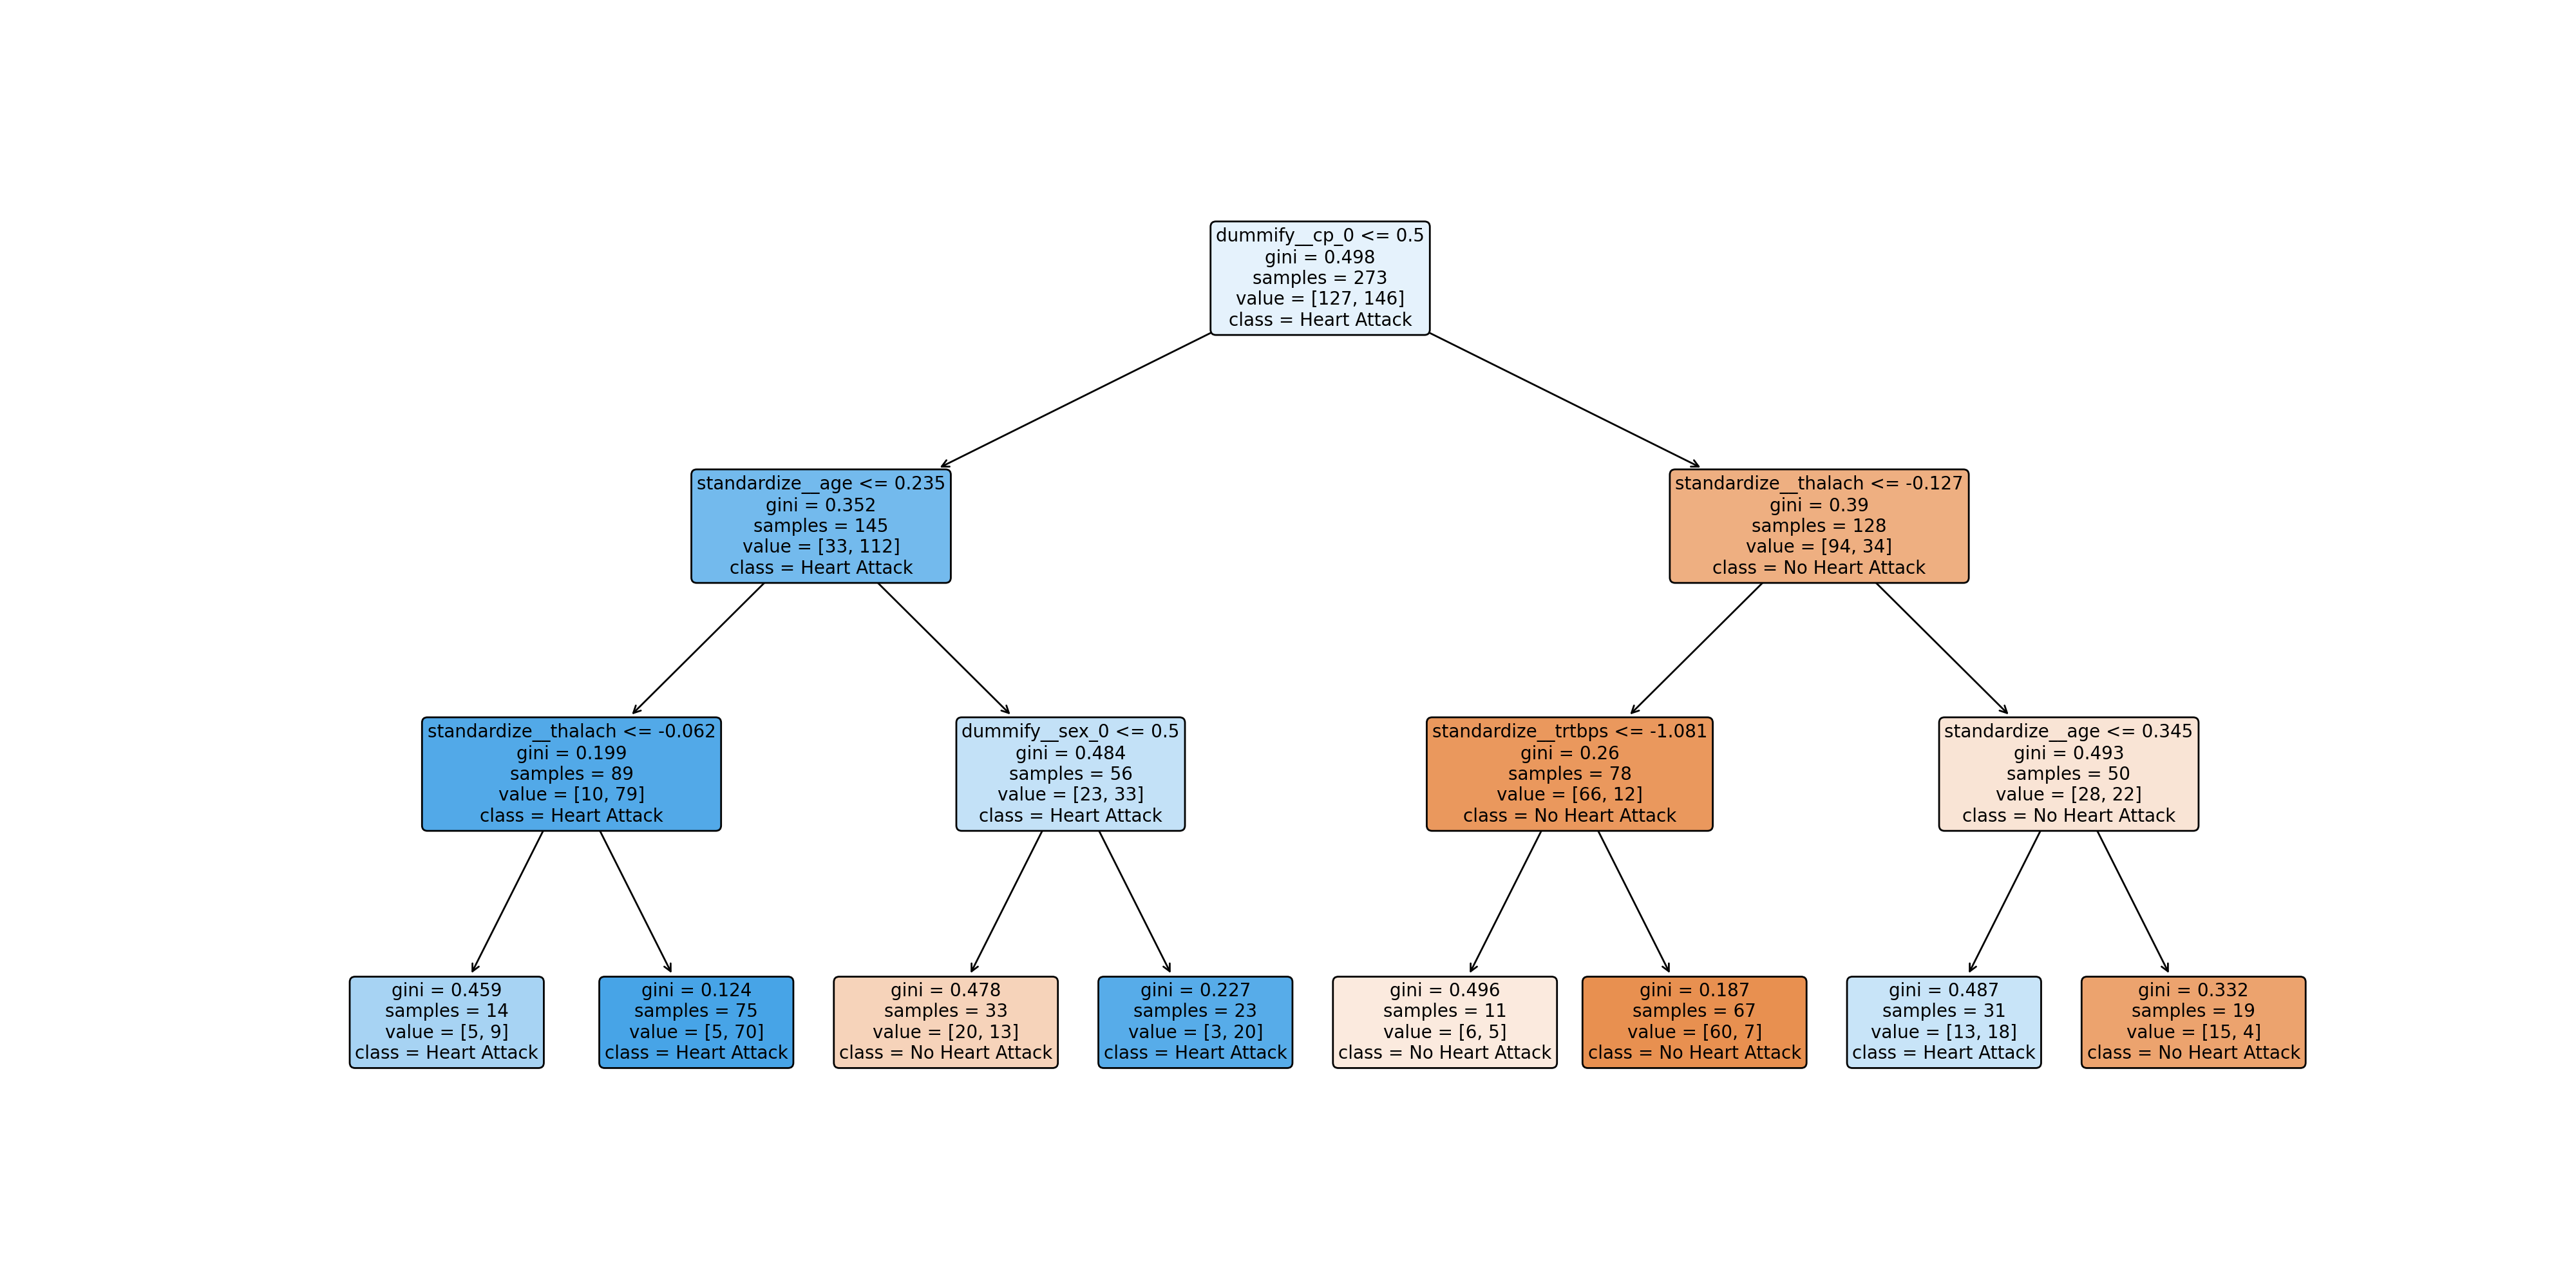

In [53]:
#extract feature names from ColumnTransformer
feature_names = decision_tree_grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

best_decision_tree_model_plot = decision_tree_grid_search.best_estimator_.named_steps['classifier']

#plot decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_decision_tree_model_plot,
          feature_names=feature_names,
          class_names=["No Heart Attack", "Heart Attack"],
          filled=True,
          rounded=True,
          fontsize=10)
plt.show()

## Interpretation

In [54]:
#extract log_reg model from pipeline
log_reg_model = best_log_reg_model.named_steps['classifier']

#find coefficients
log_reg_coefficients = log_reg_model.coef_[0]

#create df
feature_names = best_log_reg_model.named_steps['preprocessor'].get_feature_names_out()
log_reg_feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': log_reg_coefficients}).sort_values('Coefficient', ascending = False)
log_reg_feature_importance

,Feature,Coefficient
0,dummify__sex_0,0.774878
12,standardize__thalach,0.685940
3,dummify__cp_1,0.459986
4,dummify__cp_2,0.458260
7,dummify__restecg_1,0.205310
5,dummify__cp_3,0.194925
8,dummify__restecg_2,-0.094431
6,dummify__restecg_0,-0.110886
9,standardize__age,-0.210716
11,standardize__chol,-0.211245


In [55]:
#extract the decision tree model from the pipeline
decision_tree_model = best_decision_tree_model.named_steps['classifier']

#feature importances
decision_tree_importances = decision_tree_model.feature_importances_

#matching feature importances with feature names
decision_tree_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': decision_tree_importances})
decision_tree_feature_importance

,Feature,Importance
0,dummify__sex_0,0.102721
1,dummify__sex_1,0.000000
2,dummify__cp_0,0.584983
3,dummify__cp_1,0.000000
4,dummify__cp_2,0.000000
5,dummify__cp_3,0.000000
6,dummify__restecg_0,0.000000
7,dummify__restecg_1,0.000000
8,dummify__restecg_2,0.000000
9,standardize__age,0.156569


The predictors most important to predicting heart attack risk in the logistic regression model are being female and having the chest pain type typical angina.

For the decision tree, the most significant predictors are typical angina and age.

## ROC CURVE

In [56]:
#predict probabilities
probs_knn = best_knn_model.predict_proba(X_test)[:, 1]
probs_log_reg = best_log_reg_model.predict_proba(X_test)[:, 1]
probs_decision_tree = best_decision_tree_model.predict_proba(X_test)[:, 1]

#calculate ROC curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, probs_knn)
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, probs_log_reg)
fpr_decision_tree, tpr_decision_tree, thresholds_decision_tree = roc_curve(y_test, probs_decision_tree)

#calculate AUC
auc_knn = auc(fpr_knn, tpr_knn)
auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
auc_decision_tree = auc(fpr_decision_tree, tpr_decision_tree)

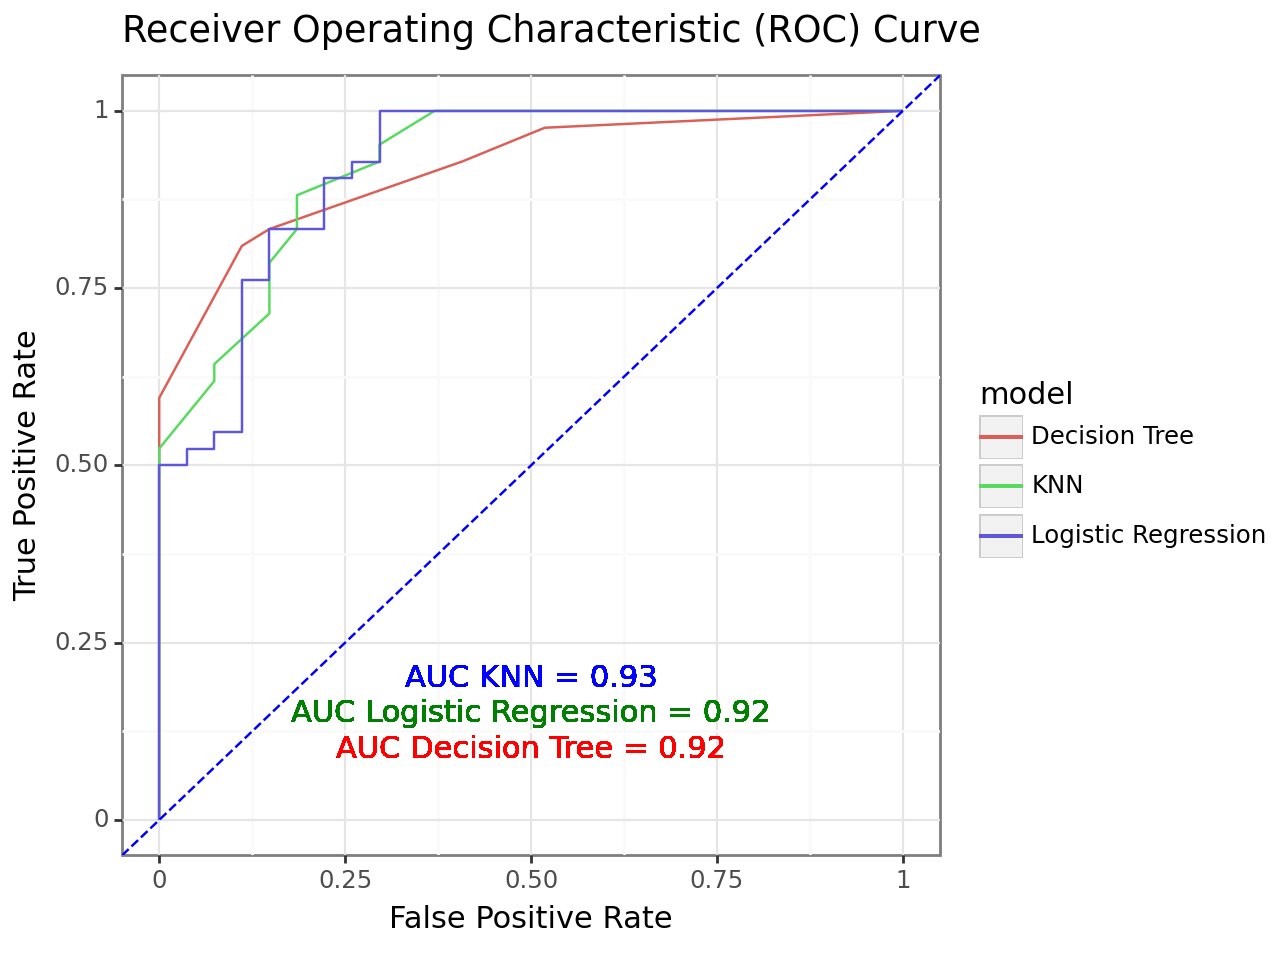

<Figure Size: (640 x 480)>

In [57]:
from plotnine import ggplot, aes, geom_line, geom_abline, labs, theme_bw, geom_text

import pandas as pd
data = pd.DataFrame({
    'fpr': np.concatenate([fpr_knn, fpr_log_reg, fpr_decision_tree]),
    'tpr': np.concatenate([tpr_knn, tpr_log_reg, tpr_decision_tree]),
    'model': ['KNN']*len(fpr_knn) + ['Logistic Regression']*len(fpr_log_reg) + ['Decision Tree']*len(fpr_decision_tree)
})

roc_plot = (ggplot(data, aes(x='fpr', y='tpr', color='model'))
            + geom_line()
            + geom_abline(linetype='dashed', color='blue')
            + labs(x='False Positive Rate', y='True Positive Rate', title='Receiver Operating Characteristic (ROC) Curve')
            + theme_bw())

#add AUC scores to plot
roc_plot = (roc_plot
            + geom_text(x=.5, y=.2, label=f'AUC KNN = {auc_knn:.2f}', color='blue')
            + geom_text(x=.5, y=.15, label=f'AUC Logistic Regression = {auc_log_reg:.2f}', color='green')
            + geom_text(x=.5, y=.1, label=f'AUC Decision Tree = {auc_decision_tree:.2f}', color='red'))
roc_plot

# Part Two: Metrics

In [58]:
def specificity_score(y_true, y_pred):
    """
    Computes specificity(the True Negative Rate) of a classifier's predictions.

    Parameters
    ----------
    y_true : array-like
        True binary labels of the data (0 or 1).
    y_pred : array-like
        Predicted binary labels from the classifier (0 or 1).

    Returns
    -------
    float
        The specificity score as a float in the range [0, 1].
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

scorers = {
    'recall': make_scorer(recall_score),  #True Positive Rate
    'precision': make_scorer(precision_score),  #Precision
    'specificity': make_scorer(specificity_score)  #True Negative Rate (Specificity)
}

#cross-validate models
cv_results_knn = cross_validate(knn_pipeline, X, y, cv=5, scoring=scorers)
cv_results_log_reg = cross_validate(log_pipeline, X, y, cv=5, scoring=scorers)
cv_results_decision_tree = cross_validate(decision_tree_pipeline, X, y, cv=5, scoring=scorers)

#compute averages
average_scores_knn = {metric: np.mean(scores) for metric, scores in cv_results_knn.items()}
average_scores_log_reg = {metric: np.mean(scores) for metric, scores in cv_results_log_reg.items()}
average_scores_decision_tree = {metric: np.mean(scores) for metric, scores in cv_results_decision_tree.items()}

In [59]:
average_scores_knn

{'fit_time': 0.010933828353881837,
 'score_time': 0.013892269134521485,
 'test_recall': 0.685287356321839,
 'test_precision': 0.7287975763782215,
 'test_specificity': 0.7}

In [60]:
average_scores_log_reg

{'fit_time': 0.014547491073608398,
 'score_time': 0.01031351089477539,
 'test_recall': 0.8156321839080458,
 'test_precision': 0.8002201038518173,
 'test_specificity': 0.7541538461538461}

In [61]:
average_scores_decision_tree

{'fit_time': 0.009307003021240235,
 'score_time': 0.008491897583007812,
 'test_recall': 0.7057471264367816,
 'test_precision': 0.7211952465325779,
 'test_specificity': 0.684}

# Part Three: Discussion

## Q1:
- Metric: Recall is the most important here. The hospital needs to minimize the number of high-risk patients who are incorrectly classified as low risk, which is captured in false negatives. Recall is the only formula that contains false negatives, and they are in the denominator, meaning minimizing false negatives leads to a high recall.
- Recommended Model: Logistic Regression has the highest recall at 0.816. This means it is most likely to correctly identify patients who are at risk of heart attacks.
- Expected Score: Expect a recall around 0.816, meaning approximately 81.6% of actual high-risk patients will be correctly identified.



## Q2:
- Metric: Precision would be the most important metric to look at. The hospital wants to ensure that the patients it admits as high risk are truly at risk, in order to optimize bed space usage. Therefore, the goal is to minimize false positives that would take up bed space. Since false positives are only in precision as a denominator, you want to maximize precision.
- Recommended Model: Logistic Regression has the highest precision at 0.800. This model will more accurately identify patients who actually need to be monitored.
- Expected Score: Expect a precision score around 0.800, indicating that about 80% of the patients identified as high risk are actually at risk.



## Q3:
- Metric: All three metrics would be able to somewhat capture the model performing well on diagnosing people correctly. In addition to that, the Coefficients of each feature in a model would indicate what features are most predictive of heart attack risk.
- Recommended Model: Logistic Regression would be the easiest model to use because it contains interpretable coefficients that indicate the relationship between each feature and the risk of heart attacks.
- Expected Outcome: Since each metric could be used in a logistic regression, one option woul dbe to go with a recall of 0.816, which would once again estimate 81.6% of high-risk patients being correctly identified.



## Q4:
- Metric: If this is the benchmark for doctors to be measured on, you want to make sure that you are balancing false positives and negatives. False negatives mean sick people are going untreated, and false positives mean healthy people are going through serious treatment with drugs and or radiation. Because of this, a combination of Recall and Precision would likely be the best.
- Recommended Model: A decision tree would be intuitive with human decisions, such as the doctors looking for signs like thresholds on cholesterol and age.
- Expected Score: The recall of the decision tree is 0.698 and the the precision is 0.717.

# Part Four: Validation

In [62]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

In [63]:
X_val = ha_validation.drop(['output'], axis = 1)
y_val = ha_validation['output']

## KNN

In [72]:
knn_fitted = best_knn_model.fit(X, y)

In [73]:
knn_val_preds = knn_fitted.predict(X_val)
knn_val_preds

array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [74]:
confusion_matrix(y_val, knn_val_preds)

array([[10,  1],
       [ 8, 11]])

In [75]:
roc_auc_score(y_val, knn_val_preds), precision_score(y_val, knn_val_preds), recall_score(y_val, knn_val_preds)

(0.7440191387559808, 0.9166666666666666, 0.5789473684210527)

In [80]:
best_knn_score

0.8431844385499557

In [81]:
average_scores_knn

{'fit_time': 0.010933828353881837,
 'score_time': 0.013892269134521485,
 'test_recall': 0.685287356321839,
 'test_precision': 0.7287975763782215,
 'test_specificity': 0.7}

Since the ROC AUC score on the validation model is lower, it shows that the previous model may have been overfit to the first dataset. Our actual precision score was much higher than our estimated precision score, but this came at the expense of the recall score which was lower than our predicted value.

## Logistic Regression

In [76]:
log_reg_fitted = best_log_reg_model.fit(X, y)

In [77]:
log_reg_val_preds = log_reg_fitted.predict(X_val)
log_reg_val_preds

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [78]:
confusion_matrix(y_val, log_reg_val_preds)

array([[ 9,  2],
       [ 4, 15]])

In [79]:
roc_auc_score(y_val, log_reg_val_preds), precision_score(y_val, log_reg_val_preds), recall_score(y_val, log_reg_val_preds)

(0.8038277511961722, 0.8823529411764706, 0.7894736842105263)

In [82]:
best_log_reg_score

0.8654182139699381

In [83]:
average_scores_log_reg

{'fit_time': 0.014547491073608398,
 'score_time': 0.01031351089477539,
 'test_recall': 0.8156321839080458,
 'test_precision': 0.8002201038518173,
 'test_specificity': 0.7541538461538461}

Our actual ROC-AUC score was lower for the validation dataset compared to the training set, indicating it may have been slightly overfit. The estimated precision was lower than the actual, but once again this came at the cost of the recall which was predicted to be higher than the actual score.

## Decision Tree

In [64]:
dt_fitted = best_decision_tree_model.fit(X, y)

In [65]:
d_tree_val_preds = dt_fitted.predict(X_val)
d_tree_val_preds

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0])

In [66]:
confusion_matrix(y_val, d_tree_val_preds)

array([[ 9,  2],
       [ 7, 12]])

In [71]:
roc_auc_score(y_val, d_tree_val_preds), precision_score(y_val, d_tree_val_preds), recall_score(y_val, d_tree_val_preds)

(0.7248803827751196, 0.8571428571428571, 0.631578947368421)

In [84]:
best_decision_tree_score

0.820613969938108

In [87]:
average_scores_decision_tree

{'fit_time': 0.009307003021240235,
 'score_time': 0.008491897583007812,
 'test_recall': 0.7057471264367816,
 'test_precision': 0.7211952465325779,
 'test_specificity': 0.684}

The validation ROC-AUC was once again lower than the training model indicated, presumably due to overfitting. The estimated precision was much lower than the actual, and the estimated recall was higher than the actual.

# Part Five: Cohen's Kappa

Cohen's Kappa measures how well the two raters of the actual y-labels and predicted y-values agree. A measurement of 1 is perfect agreement, and a measurement of -1 is complete disagreement. From research, a measurement above 0.4 is considered moderate, between 0.6 and 0.8 is substantial, and above that is great.

## KNN

In [88]:
cohen_kappa_score(y_val, knn_val_preds)

0.4303797468354431

This would be considered moderate agreement, suggesting an okay model.

## Logistic Regression

In [89]:
cohen_kappa_score(y_val, log_reg_val_preds)

0.5852534562211982

This would be considered somewhat substantial, indicating a better model.

## Decision Tree

In [70]:
cohen_kappa_score(y_val, d_tree_val_preds)

0.4104803493449781

This would be considered moderate agreement, indicating the model is okay.

Overall, using Cohen's Kappa seems to be a good idea when you need an overall measure of model ability without weighting too much for precision or recall. It provides a balance that is needed in healthcare data, where False Positives and Negatives both come with devastating consequences. Our conclusions from above still seem to somewhat favor logistic regression for its highest Cohen's Kappa and ROC-AUC, along with its interpretable coefficients. This makes sense, as a model that has the closest predictors to actual values would also have the highest ROC-AUC.

## Citations:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
- https://numpy.org/doc/stable/reference/generated/numpy.ravel.html
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3900052/#:~:text=Cohen%20suggested%20the%20Kappa%20result,1.00%20as%20almost%20perfect%20agreement.
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html


Assisted by ChatGPT:
- Additional tuning metrics for KNN, Logistic Regression, Decision Tree
- Decision Tree Visualization
- ROC Curve Plot
- Specificity Score Function
- Average Scores